In [5]:
import tensorflow as tf
import numpy as np

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import tensorflow as tf
import segmentation_models as sm

from bfseg.utils.utils import str2bool
from bfseg.data.nyu import NyuDataLoader
from bfseg.utils.metrics import IgnorantBalancedAccuracyMetric, IgnorantAccuracyMetric, IgnorantBalancedMeanIoU, \
    IgnorantMeanIoU
from bfseg.utils.losses import ignorant_cross_entropy_loss, ignorant_balanced_cross_entropy_loss
from bfseg.data.meshdist.dataLoader import DataLoader
from bfseg.experiments.Experiment import Experiment
from bfseg.utils.evaluation import scoreAndPlotPredictions
from bfseg.models.DeeplabV3Plus import Deeplabv3

Segmentation Models: using `tf.keras` framework.


In [3]:
tf.keras.models.load_model("../model.h5", custom_objects={'tf': tf})

/home/rene/tf_venv/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: bfseg.models.DeeplaabV3Plus is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [6]:
model = Deeplabv3(input_shape=(480, 720, 3),
                    classes=2,
                    OS=16)

In [79]:
dataLoaderArche = DataLoader(
       "/home/rene/cla_dataset/watershed", [480, 720],
      validationDir="/home/rene/hiveLabels",
      validationMode="ARCHE",
      batchSize=1,
      loadDepth=False,
      cropOptions={
          'top': 0,
          'bottom': 0
      })

In [46]:
c = 0
for i in dataLoaderArche.getValidationDataset().take(-1):
    print(c)
    c+=1
    if c == 15:
        break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [73]:

plt.rcParams["figure.figsize"] = (30,20)


In [75]:
from bfseg.utils.metrics import IgnorantBalancedMeanIoU, IgnorantMeanIoU, IgnorantBalancedAccuracyMetric, IgnorantAccuracyMetric
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np


def oneMetricIteration(metric, label, pred):
  """ Helper function to get the result from one prediction """
  metric.update_state(label, pred)
  res = metric.result().numpy()
  metric.reset_states()
  return res


def scoreAndPlotPredictions(imageCallback,
                            test_ds,
                            num_images,
                            plot=True,
                            outFolder=None,
                            tag="",
                            exportPredictions=False):
  """
  Calculates different metrices for the validation set provided by the dataloader.
  Also plots predictions if plot = True

  Args:
      imageCallback: lambda function that takes a batch of images and returns the prediction
      dataLoader: data.meshdist.dataLoader
      plot: Flag whether to plot the results or not
      batchSize: How many images are loaded with each batch
      outFolder: Where to store the prediction
      tag: tag appended to the prediction results
      exportPredictions: Flag whether or not to export predicted images

  """
  iam = IgnorantAccuracyMetric()
  ibm = IgnorantBalancedAccuracyMetric()

  # object assigned the 0 label is background, assigned the 1 label is foreground.
  # False Pos: background that is interpreted as foregound
  FPM = tf.keras.metrics.FalsePositives(
  )  # object assigned the 0 label is background, assigned the 1 label is foreground.
  # False Neg: Foreground that is interpreted as background
  FNM = tf.keras.metrics.FalseNegatives()
  TNM = tf.keras.metrics.TrueNegatives()
  TPM = tf.keras.metrics.TruePositives()

  MIOUM_B = IgnorantBalancedMeanIoU()
  MIOUM = IgnorantMeanIoU()

  # Valid metrices accumulate results over whole validation set.
  # Other metrices are only used to calculate results for every image.
  FPM_valid = tf.keras.metrics.FalsePositives(
  )  # object assigned the 0 label is background, assigned the 1 label is foreground.
  # False Neg: Foreground that is interpreted as background
  FNM_valid = tf.keras.metrics.FalseNegatives()
  TNM_valid = tf.keras.metrics.TrueNegatives()
  TPM_valid = tf.keras.metrics.TruePositives()
  iam_valid = IgnorantAccuracyMetric()
  ibm_valid = IgnorantBalancedAccuracyMetric()

  MIOUM_B_valid = IgnorantBalancedMeanIoU()
  MIOUM_valid = IgnorantMeanIoU()

  #remaining_images = num_images % batchSize
  
  cnt = 0
  for test_img, test_label in test_ds.take(-1):
    pred = imageCallback(test_img)
    print(f"Scoring image {cnt+1} from {num_images}")
    if cnt >= num_images:
        break
        
    for i in range(pred.shape[0]):
      if cnt >= num_images:
        break
      cnt += 1  

      # Convert prediction to categorical form
      pred_categorical = tf.argmax(pred[i], axis=-1)

      # True false label needed for True Positive, False Negatives, ....
      label_true_false = test_label[i] > 0

      FN = oneMetricIteration(FNM, label_true_false, pred_categorical)
      FP = oneMetricIteration(FPM, label_true_false, pred_categorical)
      TP = oneMetricIteration(TPM, label_true_false, pred_categorical)
      TN = oneMetricIteration(TNM, label_true_false, pred_categorical)

      FPM_valid.update_state(label_true_false, pred_categorical)
      FNM_valid.update_state(label_true_false, pred_categorical)
      TNM_valid.update_state(label_true_false, pred_categorical)
      TPM_valid.update_state(label_true_false, pred_categorical)

      # Update Accuracy metrics
      iam_value = oneMetricIteration(iam, test_label[i, ...], pred[i, ...])
      ibm_value = oneMetricIteration(ibm, test_label[i, ...], pred[i, ...])
      iam_valid.update_state(test_label[i, ...], pred[i, ...])
      ibm_valid.update_state(test_label[i, ...], pred[i, ...])

      mIoU = oneMetricIteration(MIOUM, test_label[i, ...], pred[i, ...])
      mIoU_B = oneMetricIteration(MIOUM_B, test_label[i, ...], pred[i, ...])

      MIOUM_valid.update_state(test_label[i, ...], pred[i, ...])
      MIOUM_B_valid.update_state(test_label[i, ...], pred[i, ...])

      if plot:
        plt.subplot(num_images//5, 5, cnt)
        plt.imshow(tf.argmax(pred[i], axis=-1))
        plt.imshow(test_img[i], alpha=0.7)
        plt.title(
            f"mIoU: {mIoU:.4f}, mIoU_B: {mIoU_B:.4f}\nIAM: {iam_value:.4f}, IBM: {ibm_value:.4f}\nTPR: {TP / (FP + FN):.4f}, TNR {TN / (TN + FP):.4f} "
        )

      # Export results as csv
      if outFolder is not None:
        img_name = tag + "_" + str(cnt).zfill(3) + ".png"
        # Create csv entry for each image
        with open(os.path.join(outFolder, "results_one_by_one_" + tag + ".csv"),
                  "a+") as f:
          f.write(
              f"{img_name},{iam_value:.4f},{ibm_value:.4f},{mIoU:.4f},{mIoU_B:.4f}\n"
          )

        # Export predicted images if requested
        if exportPredictions:
          imgs_folder = os.path.join(outFolder, "imgs")
          if not os.path.exists(imgs_folder):
            os.mkdir(imgs_folder)

          Image.fromarray(np.uint8(tf.argmax(pred[i], axis=-1)), 'L').save(
              os.path.join(imgs_folder, "pred_" + img_name))
          Image.fromarray(np.uint8(np.squeeze(test_label[i])),
                          'L').save(os.path.join(imgs_folder, "gt_" + img_name))
          Image.fromarray(np.uint8(test_img[i] * 255)).save(
              os.path.join(imgs_folder, "img_" + img_name))


  FP = FPM_valid.result().numpy()
  FN = FNM_valid.result().numpy()
  TN = TNM_valid.result().numpy()
  TP = TPM_valid.result().numpy()

  iam_valid_value = iam_valid.result().numpy()
  MIOUM_valid_value = MIOUM_valid.result().numpy()
  ibm_valid_value = ibm_valid.result().numpy()
  MIOUM_B_valid_value = MIOUM_B_valid.result().numpy()

  print("Accuracy on validation set:", iam_valid_value)
  print("Balanced Accuracy on validation set:", ibm_valid_value)
  print("mIoU on validation set:", MIOUM_valid_value)
  print("Balanced mIoU on validation set:", MIOUM_B_valid_value)

  print("Positive = Foreground, Negative = Background")
  print("TPR on validation set:", TP / (TP + FN))
  print("TNR on validation set:", TN / (TN + FP))
  print("Precision  on validation set:", TP / (TP + FP))

  # Export results.csv containing accuracy and iou information
  if outFolder is not None:
    with open(os.path.join(outFolder, "results.csv"), "a+") as f:
      f.write(
          f"{tag},{iam_valid_value:.4f},{ibm_valid_value:.4f},{MIOUM_valid_value:.4f},{MIOUM_B_valid_value:.4f}\n"
      )


Scoring image 1 from 20
Scoring image 2 from 20
Scoring image 3 from 20
Scoring image 4 from 20
Scoring image 5 from 20
Scoring image 6 from 20
Scoring image 7 from 20
Scoring image 8 from 20
Scoring image 9 from 20
Scoring image 10 from 20
Scoring image 11 from 20
Scoring image 12 from 20
Scoring image 13 from 20
Scoring image 14 from 20
Scoring image 15 from 20
Scoring image 16 from 20
Scoring image 17 from 20
Scoring image 18 from 20
Scoring image 19 from 20
Scoring image 20 from 20
Accuracy on validation set: 0.36777228
Balanced Accuracy on validation set: 0.40183386
mIoU on validation set: 0.22157007
Balanced mIoU on validation set: 0.24163303
Positive = Foreground, Negative = Background
TPR on validation set: 0.2083932
TNR on validation set: 0.61770415
Precision  on validation set: 0.46086398


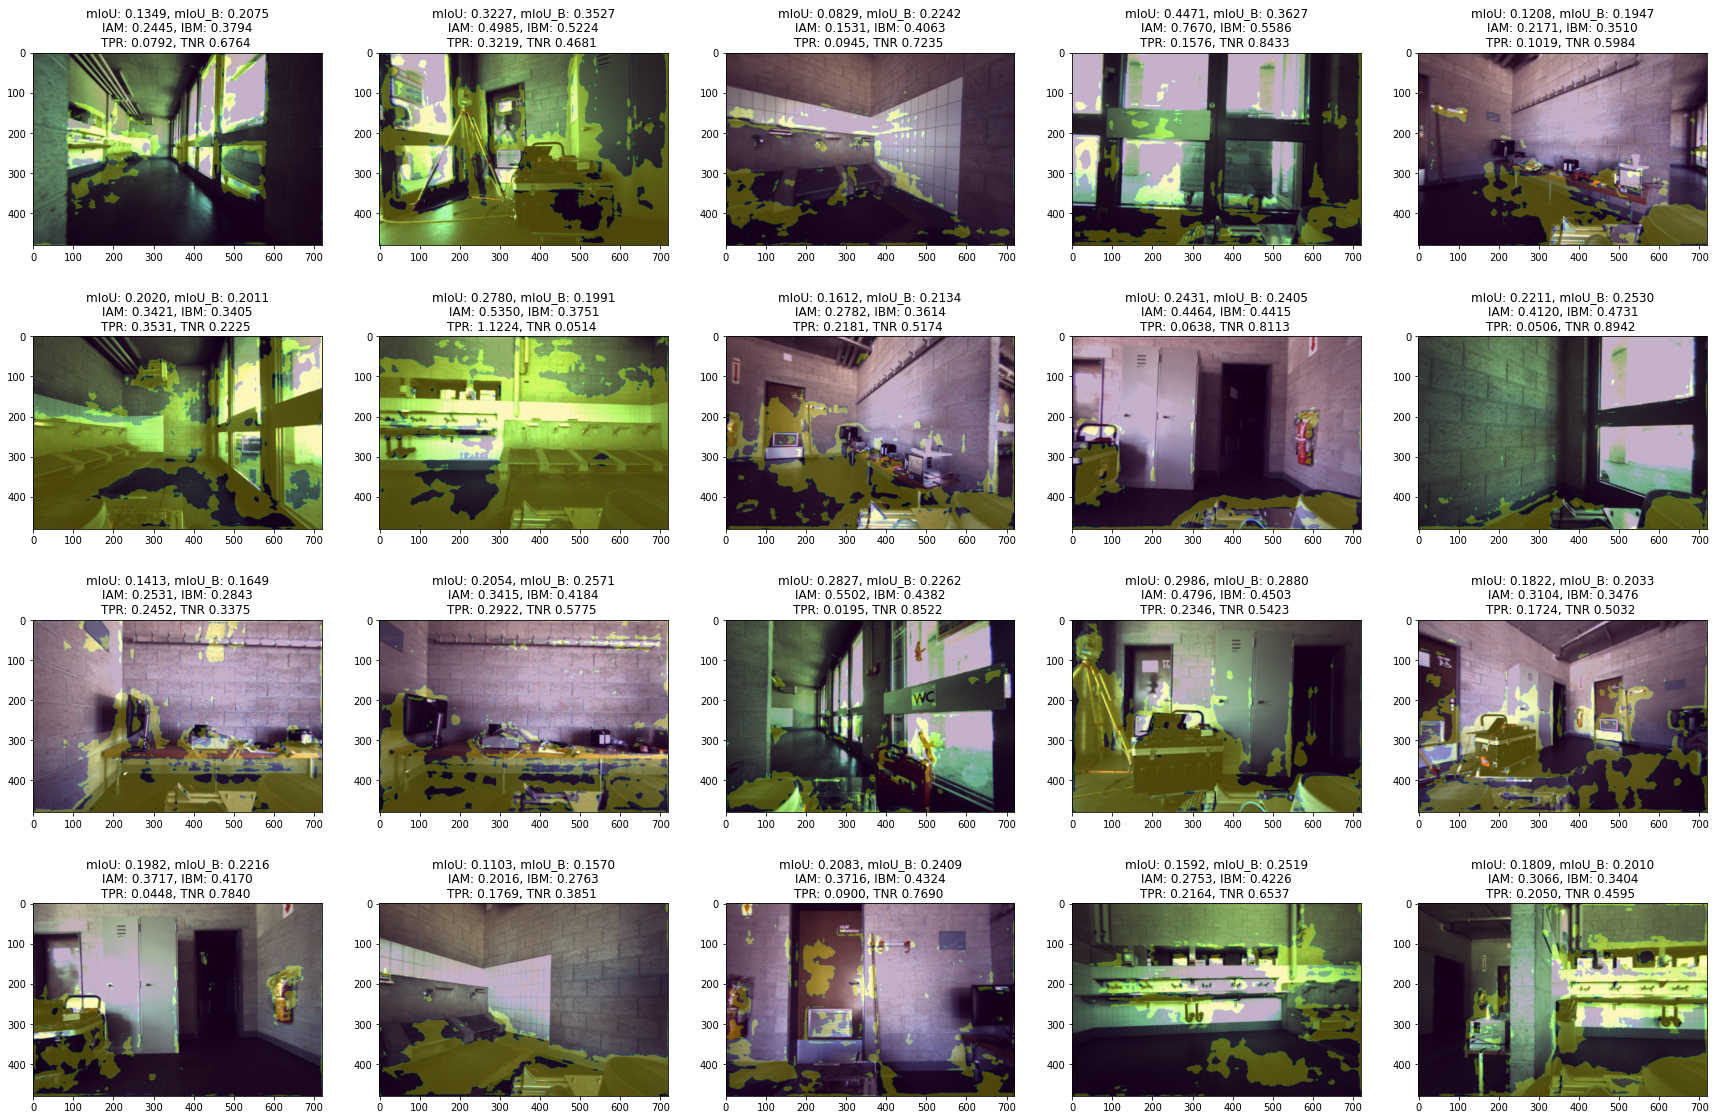

In [80]:
scoreAndPlotPredictions(lambda img: model.predict(img),
                        dataLoaderArche.getValidationDataset(),
                        dataLoaderArche.validationSize,
                        plot=True,
                        outFolder=None,
                        tag=None,
                        exportPredictions=False)

Scoring image 1 from 20
Scoring image 4 from 20
Scoring image 7 from 20
Scoring image 10 from 20
Scoring image 13 from 20
Scoring image 16 from 20
Scoring image 19 from 20
Accuracy on validation set: 0.36777228
Balanced Accuracy on validation set: 0.40183386
mIoU on validation set: 0.22157007
Balanced mIoU on validation set: 0.24163303
Positive = Foreground, Negative = Background
TPR on validation set: 0.2083932
TNR on validation set: 0.61770415
Precision  on validation set: 0.46086398


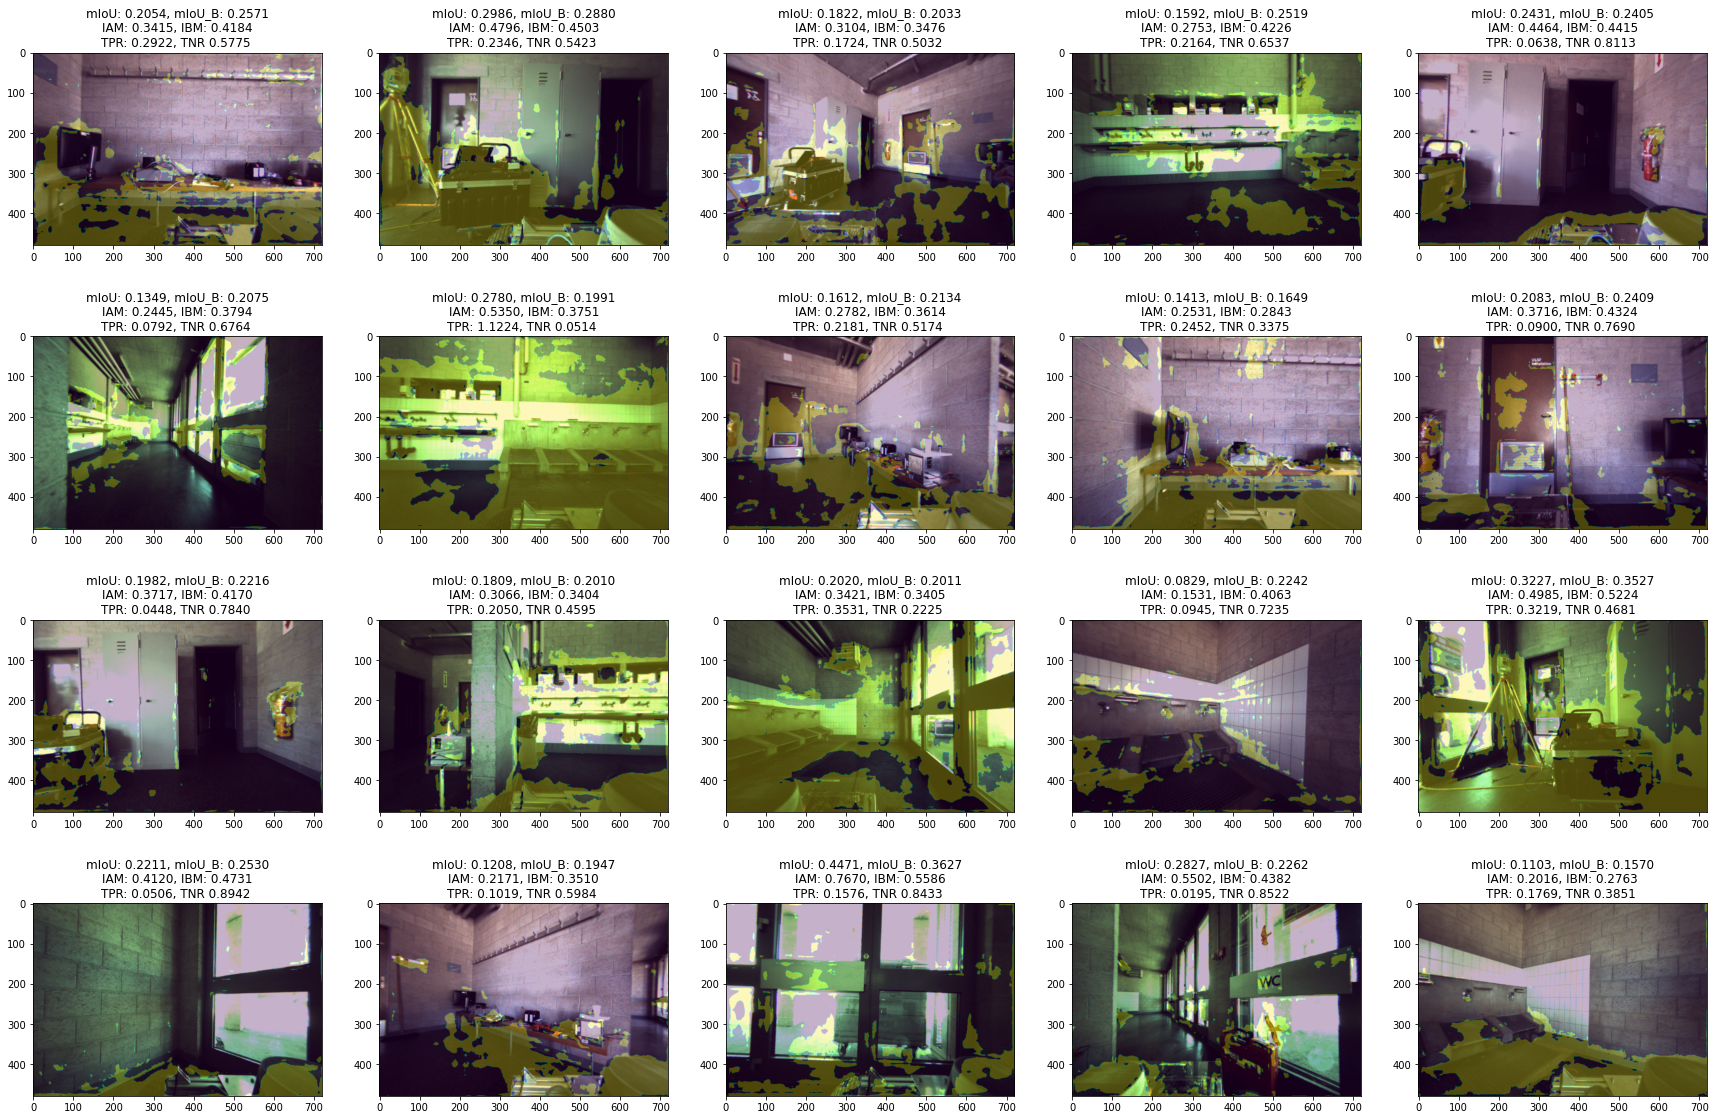

In [78]:
scoreAndPlotPredictions(lambda img: model.predict(img),
                        dataLoaderArche.getValidationDataset(),
                        dataLoaderArche.validationSize,
                        plot=True,
                        outFolder=None,
                        tag=None,
                        exportPredictions=False)

In [32]:
scoreAndPlotPredictions(lambda img: model.predict(img),
                        dataLoaderArche.getValidationDataset(),
                        dataLoaderArche.validationSize,
                        plot=False,
                        batchSize=4,
                        outFolder=None,
                        tag=None,
                        exportPredictions=False)

0
Scoring batch 0 from 5
Scoring batch 1 from 5
Scoring batch 2 from 5
Scoring batch 3 from 5
Scoring batch 4 from 5
Accuracy on validation set: 0.40865567
Balanced Accuracy on validation set: 0.42790294
mIoU on validation set: 0.25679892
Balanced mIoU on validation set: 0.26820847
Positive = Foreground, Negative = Background
TPR on validation set: 0.31763554
TNR on validation set: 0.5734423
Precision  on validation set: 0.5741315
